In [9]:
import torch 
import pandas as pd
import numpy as np
from amlvae.models.VAE import VAE

import shap
from matplotlib import pyplot as plt
import gseapy as gp
import umap 
import seaborn as sbn

from sklearn.cluster import OPTICS, DBSCAN, HDBSCAN

from amlvae.models.MLP import MLP

import networkx as nx 

import captum
from captum.attr import IntegratedGradients

# Contrastive Explanation with Integrated Gradients

**Premise**

In latent-space analyses of variational autoencoder (VAE) embeddings, we often seek explanations for why specific pairs of observations are close together. Standard feature attribution methods, like Integrated Gradients (IG), explain single predictions or outcomes. However, similarity in latent space is inherently relational: it involves comparisons between multiple points. Thus, explanations must explicitly contrast pairs of similar observations against the broader dataset.

**Method**

To generate intuitive contrastive explanations, we utilize Integrated Gradients with multiple realistic baselines drawn from the dataset. Specifically, given two observations $( x_1 )$ and  $( x_2 )$, we explain their proximity relative to all other points. Our goal is to identify input features (genes) responsible for making $( x_1 )$ and  $( x_2 )$ similar in latent space compared to typical samples.

The procedure is:

1. **Compute latent-space similarity** between $( x_1 )$ and $( x_2 )$:

$$
s(x_1, x_2) = -||f(x_1) - f(x_2)||_2
$$

where ($ f(\cdot) $) is the VAE encoder.

2. **Contrast against realistic baselines**. Define \( X_{\text{contrastive}} \) as the dataset excluding $( x_1 )$ and $( x_2 )$. Compute Integrated Gradients attributions for each baseline $( x_b \in X_{\text{contrastive}} )$:

$$
\text{IG}(x_2, x_b) = (x_2 - x_b) \odot \int_{\alpha=0}^{1} \frac{\partial s(x_b + \alpha(x_2 - x_b))}{\partial x_2} d\alpha
$$

3. **Aggregate attribution results** over all baselines:

$$
\text{Importance}(x_2) = \frac{1}{|X_{\text{contrastive}}|}\sum_{x_b \in X_{\text{contrastive}}}\text{IG}(x_2, x_b)
$$

The resulting importance scores quantify how each feature specifically contributes to making $( x_1 )$ and $( x_2 )$ similar compared to typical samples.

**Rationale**

This approach provides explicitly contrastive explanations grounded in realistic data distributions. Using actual observations as baselines contextualizes explanations, highlighting features uniquely responsible for latent-space similarities. Aggregating results ensures robust, stable interpretations, yielding biologically meaningful insights such as identifying genes uniquely responsible for observed similarities.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('../output/vae_l12_4-24-25.pt', weights_only=False)

model = model.to(device)
model = model.eval()

expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32, device=device)


In [4]:
xhat = model.decode(model.encode(X)[0])
print('mse:', torch.mean((xhat - X) ** 2).item())
print('r2:', 1 - torch.mean((xhat - X) ** 2).item() / torch.var(X).item())

mse: 0.33217853307724
r2: 0.699553424473499


# Compute nearest neighbor graph 

In [5]:
z = model.encode(torch.tensor(X, dtype=torch.float32).to(device))[0].cpu().detach().numpy()

/tmp/ipykernel_26105/3689117051.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = model.encode(torch.tensor(X, dtype=torch.float32).to(device))[0].cpu().detach().numpy()


In [25]:
from sklearn.neighbors import NearestNeighbors 

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(z)

G = nx.Graph(nn.kneighbors_graph()) 

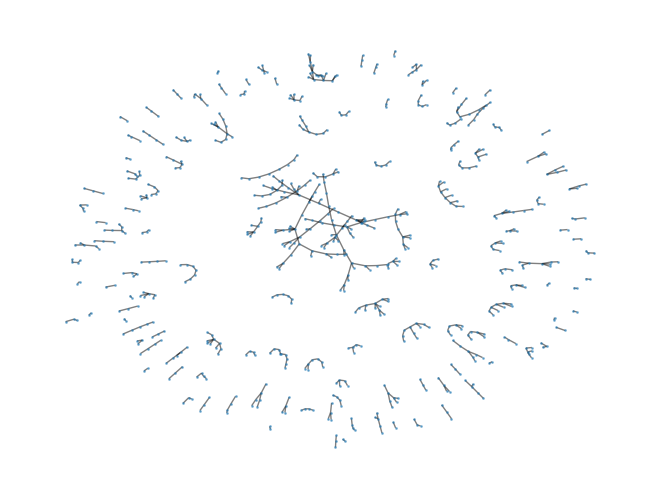

In [26]:
plt.figure()
nx.draw(G, node_size=1, alpha=0.5)
plt.show()

# create function evaluating the similarity between two given points 

In [55]:

class func(torch.nn.Module): 
    def __init__(self, vae, x1): 
        super().__init__()
        self.vae = vae.eval()
        self.x1 = x1

    def forward(self, x2):

        z1 = self.vae.encode(self.x1)[0]
        z2 = self.vae.encode(x2)[0]
        
        l2 = torch.mean((z1 - z2) ** 2, dim=1) 
        
        return l2
    

# perform shap to predict cluster assignments 

In [56]:
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32).to(device)

In [57]:
# zero baseline 
z0 = torch.zeros(1,12).to(device)
x0 = model.decode(z0)

In [64]:
# choose nearest negihbor pair to use 
x1_idx, x2_idx = list(G.edges())[0]
x1 = X[x1_idx].unsqueeze(0).to(device)
x2 = X[x2_idx].unsqueeze(0).to(device)

contrastive_baseline_mask = torch.ones(X.shape[0], dtype=torch.bool)
contrastive_baseline_mask[x1_idx] = False
contrastive_baseline_mask[x2_idx] = False 
contrastive_candidates = contrastive_baseline_mask.nonzero(as_tuple=True)[0]
contrastive_idxs = np.random.choice(contrastive_candidates, size=500, replace=False)
x_contrastive = X[contrastive_idxs].to(device) 

# expand x2 to match the size of x_contrastive 
#x2 = x2.expand(x_contrastive.shape[0], -1)

print('x1', x1.size())
print('x2', x2.size())
print('baselines', x_contrastive.size())

x1 torch.Size([1, 2500])
x2 torch.Size([1, 2500])
baselines torch.Size([500, 2500])


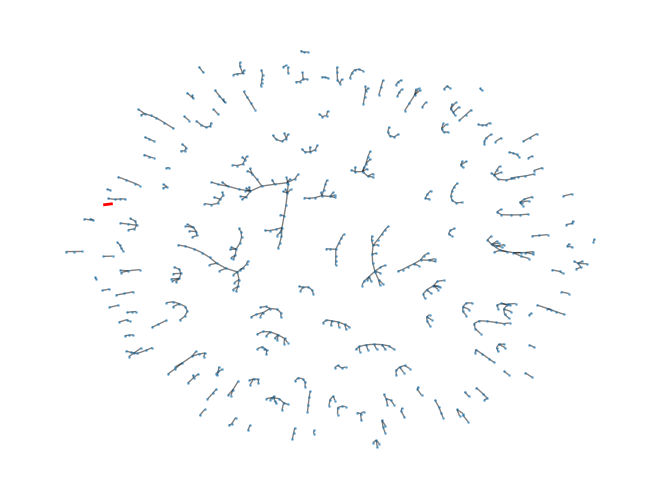

In [65]:
plt.figure()
nx.draw(G, node_size=1, alpha=0.5)
nx.draw_networkx_edges(G, pos=nx.spring_layout(G), edgelist=[(x1_idx, x2_idx)], edge_color='r', width=2)
plt.show()

In [ ]:
f = func(model, x1)
integrated_gradients = IntegratedGradients(f)

attr_list = []
for i,baseline in enumerate(x_contrastive):
    print(f'progress: {i}/{x_contrastive.shape[0]}', end='\r')
    attr = integrated_gradients.attribute(
        inputs=x2, 
        baselines=baseline.unsqueeze(0), 
        n_steps=100
    )
    attr_list.append(attr.detach().cpu().numpy())

scores = np.mean(np.stack(attr_list), axis=0).ravel()


In [84]:
ig_res = pd.DataFrame(scores, index=expr.columns[1:], columns=['IG'])
ig_res = ig_res.sort_values('IG', ascending=False).reset_index() .rename(columns={'index': 'gene_symbol'})
ig_res.head()

,gene_symbol,IG
0,AC092670.1,0.025946
1,PTMAP5,0.019849
2,MAP4K2,0.018574
3,RPL41P1,0.016743
4,PTMAP2,0.015919


In [ ]:

# run prerank GSEA with Reactome_2016
prerank_res = gp.prerank(
    rnk=ig_res,
    gene_sets=["Reactome_2016"],
    outdir=None,         # don't write files to disk
    permutation_num=1000, 
    seed=0
)


In [88]:
prerank_res.res2d.sort_values('FDR q-val').sort_values('FDR q-val').head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3,prerank,Reactome_2016__Senescence-Associated Secretory...,-0.695864,-1.617008,0.002242,0.190626,0.349,10/17,21.64%,CXCL8;JUN;UBC;CDKN2D;CEBPB;IGFBP7;RELA;FOS;CDK...
2,prerank,Reactome_2016__Golgi Associated Vesicle Biogen...,-0.704897,-1.630602,0.007659,0.196511,0.296,5/16,8.36%,AP1B1;SNX2;FTH1;TFRC;FTL
0,prerank,Reactome_2016__trans-Golgi Network Vesicle Bud...,-0.679594,-1.636204,0.005394,0.267132,0.276,6/21,8.36%,AP1B1;SNX2;CHMP2A;FTH1;TFRC;FTL
1,prerank,Reactome_2016__Clathrin derived vesicle buddin...,-0.679594,-1.636204,0.005394,0.267132,0.276,6/21,8.36%,AP1B1;SNX2;CHMP2A;FTH1;TFRC;FTL
5,prerank,Reactome_2016__MHC class II antigen presentati...,-0.634197,-1.561783,0.006472,0.292378,0.606,13/23,24.52%,AP1B1;HLA-DPA1;CD74;HLA-DQB1;HLA-DPB1;HLA-DRB5...
4,prerank,Reactome_2016__Signaling by FGFR in disease Ho...,-0.666259,-1.566647,0.015251,0.327723,0.58,3/17,4.00%,MYO18A;POLR2L;NRAS
33,prerank,Reactome_2016__SLC-mediated transmembrane tran...,-0.503785,-1.28605,0.130389,0.895257,1.0,13/30,28.24%,SLC38A1;BSG;SLC39A6;SLC3A2;SLC12A7;SLC39A7;RUN...
35,prerank,Reactome_2016__Platelet degranulation Homo sap...,-0.494854,-1.277923,0.128931,0.900932,1.0,8/30,16.92%,PLEK;SPARC;SRGN;CTSW;LAMP2;QSOX1;TMSB4X;F13A1
34,prerank,Reactome_2016__RNA Polymerase II Transcription...,-0.527143,-1.281328,0.128723,0.902079,1.0,7/22,22.32%,POLR2L;TAF12;SLU7;ALYREF;CTDP1;SLBP;EIF4A3
32,prerank,Reactome_2016__The citric acid (TCA) cycle and...,-0.511634,-1.287692,0.123045,0.911252,1.0,9/26,19.44%,CYCS;BSG;MPC2;COX7C;UCP2;COX6C;COX7B;UQCRFS1;LDHA


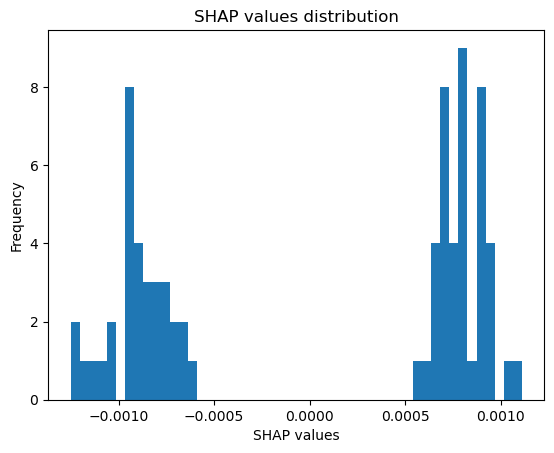

In [19]:
plt.figure()
plt.hist(importance_scores[:,0].ravel(), bins=50)
#plt.yscale('log')
plt.xlabel('SHAP values')
plt.ylabel('Frequency')
plt.title('SHAP values distribution')
plt.show()

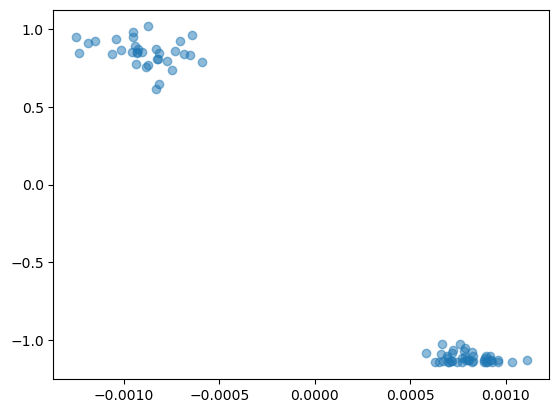

In [21]:
plt.figure()
plt.plot(importance_scores[:,0].ravel(), cluster_x[:,0].ravel(), 'o', alpha=0.5)

In [250]:
enr_bg.results.head(10)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Disease Homo sapiens R-HSA-1643685,0.002309,0.102884,0,0,9.095238,55.217523,ADAMTS2;JAG1;SDC4;CD9
1,Reactome_2016,TNFs bind their physiological receptors Homo s...,0.003494,0.102884,0,0,42.304348,239.306583,TNFRSF18;TNFRSF4
2,Reactome_2016,TNFR2 non-canonical NF-kB pathway Homo sapiens...,0.005734,0.102884,0,0,28.173913,145.416894,TNFRSF18;TNFRSF4
3,Reactome_2016,Diseases of glycosylation Homo sapiens R-HSA-3...,0.011675,0.102884,0,0,16.869565,75.074545,ADAMTS2;SDC4
4,Reactome_2016,Collagen biosynthesis and modifying enzymes Ho...,0.011675,0.102884,0,0,16.869565,75.074545,ADAMTS2;COL4A5
5,Reactome_2016,Extracellular matrix organization Homo sapiens...,0.012635,0.102884,0,0,5.271709,23.044245,ADAMTS2;SDC4;COL4A5;ELANE
6,Reactome_2016,Collagen formation Homo sapiens R-HSA-1474290,0.019408,0.102884,0,0,12.024845,47.402564,ADAMTS2;COL4A5
7,Reactome_2016,Sperm:Oocyte Membrane Binding Homo sapiens R-H...,0.025000,0.102884,0,0,inf,inf,CD9
8,Reactome_2016,Fertilization Homo sapiens R-HSA-1187000,0.025000,0.102884,0,0,inf,inf,CD9
9,Reactome_2016,Reproduction Homo sapiens R-HSA-1474165,0.025000,0.102884,0,0,inf,inf,CD9


In [235]:
enr_bg.results.head()

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Collagen degradation Homo sapiens R-HSA-1442490,0.012327,0.446153,0,0,6.208333,27.291529,MMP2;MMP19;PRSS2;ELANE
1,Reactome_2016,Degradation of the extracellular matrix Homo s...,0.016149,0.446153,0,0,4.253589,17.549928,MMP2;MMP19;LAMC1;PRSS2;ELANE
2,Reactome_2016,Aflatoxin activation and detoxification Homo s...,0.027783,0.446153,0,0,18.346939,65.742952,ACY3;MGST1
3,Reactome_2016,Extracellular matrix organization Homo sapiens...,0.029062,0.446153,0,0,2.521739,8.922745,ADAMTS2;CEACAM6;MMP2;COL4A5;MMP19;LAMC1;PRSS2;...
4,Reactome_2016,Rho GTPase cycle Homo sapiens R-HSA-194840,0.051958,0.446153,0,0,9.163265,27.098654,ARHGAP22;DLC1


In [5]:
expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values

In [6]:
z = f(X) 
z.shape

(717, 12)

In [7]:
reducer = umap.UMAP() 
u = reducer.fit_transform(z)

df = pd.DataFrame(z, columns=[f'Z{i}' for i in range(z.shape[1])]).assign(u1=u[:, 0], u2=u[:, 1])
df.head()

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,u1,u2
0,0.401562,-3.661939,2.575311,2.457817,-1.251617,-1.782826,-0.470557,-3.665357,-0.088706,-2.171198,0.704312,-2.857019,0.449669,1.371819
1,1.234304,-2.859714,4.125150,3.190236,-0.199223,0.966852,1.227564,-1.557224,3.192834,1.886375,-3.095883,-2.409158,-0.496387,2.344685
2,3.871517,0.680781,0.598997,2.336961,-0.502269,0.776640,-0.910013,-1.052591,-0.575642,0.158573,2.413478,2.692233,-2.158190,-3.149235
3,-2.303520,-2.616863,0.276941,-2.032356,-0.722825,-0.023454,2.114030,3.916564,-0.155495,2.661231,-2.392552,1.409396,-2.200017,1.520345
4,1.332419,0.540172,-1.022666,-3.386779,-1.451896,0.752559,-2.743731,0.388017,-1.432925,1.060596,0.525343,0.941352,1.709406,-1.385198


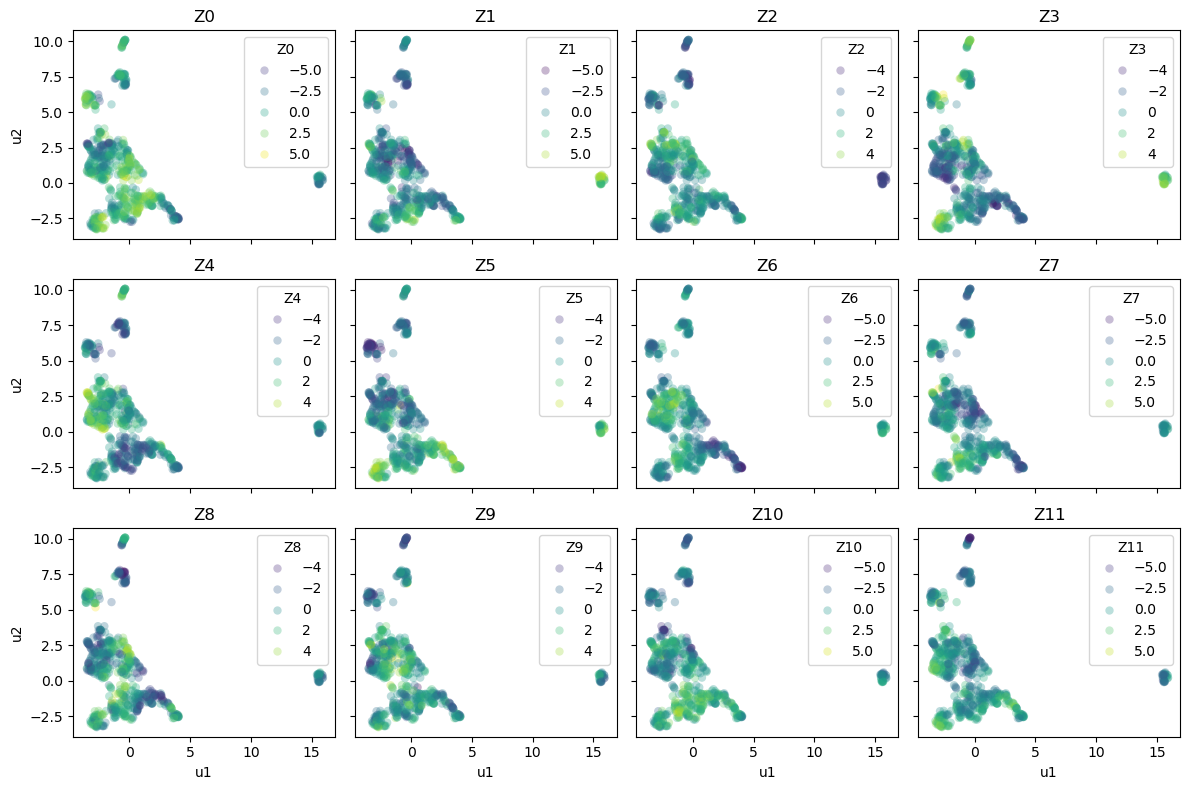

In [19]:
f,axes = plt.subplots(3,4, figsize=(12, 8), sharex=True, sharey=True)

for i in range(12):
    sbn.scatterplot(data=df, x='u1', y='u2', hue=f'Z{i}', linewidth=0, alpha=0.3, ax=axes.flat[i], palette='viridis')
    axes.flat[i].set_title(f'Z{i}')

plt.tight_layout()
plt.show() 

In [ ]:
background_mask = np.random.rand(X.shape[0]) < 0.1
rest_mask = ~background_mask
explainer = shap.KernelExplainer(f, X[background_mask, :])
shap_values = explainer.shap_values(X[rest_mask, :], nsamples=250)

In [70]:
shap_values = explainer.shap_values(X[rest_mask, :], nsamples=250)

  0%|          | 0/645 [00:00<?, ?it/s]

In [71]:
shap_values.shape # (n_samples, n_features, n_latent)

(645, 1000, 12)

In [72]:
genes = expr.columns[1:]

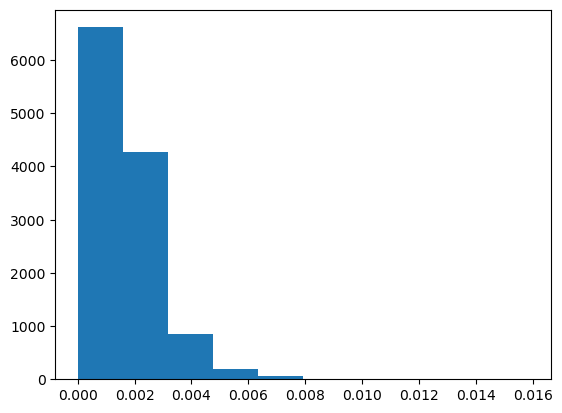

In [84]:
plt.figure()
plt.hist( np.abs(shap_values[:, :, :]).mean(axis=0).ravel() ) 
plt.show() 

In [ ]:

t = 0.004

for i in range(12): 
    print('########################'*2)
    print('########################'*2)
    print('latent dim:', i)
    print() 
    df = pd.DataFrame({'abs_mean_shap':np.abs( shap_values[:, :, i] ).mean(axis=0) , 'genes':genes})
    df = df.sort_values(by='abs_mean_shap', ascending=False)

    genelist = df[lambda x: x.abs_mean_shap >= t].genes.values.tolist()
    print('n genes:', len(genelist))
    background = df.genes.values.tolist()

    enr_bg = gp.enrichr(gene_list=genelist,
                    gene_sets=['Reactome_2016'],
                    # organism='human', # organism argment is ignored because user input a background
                    background=background,
                    outdir=None, # don't write to disk
                    )

    print(enr_bg.results[lambda x: x['Adjusted P-value'] < 0.1].Term.values) 

################################################
################################################
latent dim: 0

n genes: 45
[]
################################################
################################################
latent dim: 1

n genes: 45
['DAP12 interactions Homo sapiens R-HSA-2172127'
 'Downstream signal transduction Homo sapiens R-HSA-186763'
 'Downstream signaling of activated FGFR2 Homo sapiens R-HSA-5654696'
 'Downstream signaling of activated FGFR4 Homo sapiens R-HSA-5654716'
 'Downstream signaling of activated FGFR3 Homo sapiens R-HSA-5654708'
 'Downstream signaling of activated FGFR1 Homo sapiens R-HSA-5654687'
 'DAP12 signaling Homo sapiens R-HSA-2424491'
 'NGF signalling via TRKA from the plasma membrane Homo sapiens R-HSA-187037'
 'Signaling by SCF-KIT Homo sapiens R-HSA-1433557'
 'Signaling by FGFR3 Homo sapiens R-HSA-5654741'
 'Signaling by FGFR4 Homo sapiens R-HSA-5654743'
 'Signaling by FGFR1 Homo sapiens R-HSA-5654736'
 'Signaling by FGFR2 Homo sapiens R-